# Анализ настроений для прогнозирования курса акций.

In [ ]:
!pip install flair
!pip install yfinance
import pandas as pd

## Пользовательские функции и токены авторизации

Функция для очистки полученных данных

In [ ]:
import re
whitespace = re.compile(r"\s+")
web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
user = re.compile(r"(?i)@[a-z0-9_]+")
retweets = re.compile(r"RT :") #нужно для второй части, Cursor загружает без ретвитов

In [ ]:
def clean_data(data):
  data = web_address.sub(' ', data)
  data = user.sub(' ', data)
  data = whitespace.sub(' ', data)
  data = retweets.sub('', data)
  return data

Токены авторизации

In [ ]:
file = open('tokens.txt','r')
tokens = file.read().split()
file.close()

## Загрузка предобученной модели

In [ ]:
from flair.models import TextClassifier
from flair.data import Sentence
sentiment_model = TextClassifier.load('en-sentiment')

## Подключение с tweepy и тест классификатора

In [ ]:
import tweepy
auth = tweepy.AppAuthHandler(tokens[0], tokens[1])
api = tweepy.API(auth)

In [ ]:
def get_tweets(company_name,tweets_number):
  df = pd.DataFrame()
  try:
    for tweet in tweepy.Cursor(api.search,
                               q= company_name,
                               lang = 'en',
                               tweet_mode="extended",
                               wait_on_rate_limit = True).items(tweets_number):
      if not tweet.retweeted and 'RT @' not in tweet.full_text:
        data = {
        'id': tweet.id_str,
        'created_at': tweet.created_at,
        'text': tweet.full_text,
        'user_name': tweet.user.screen_name,
        'followers_count': tweet.user.followers_count
        }
        df = df.append(data, ignore_index=True)
    return df
  except tweepy.TweepError as e:
    print('Проблема с API')
    print(e.reason)
  except Exception:
    print(Exception)

In [ ]:
data = get_tweets('Tesla',100)
data.head()

,created_at,followers_count,id,text,user_name
0,2021-05-27 12:45:11,2889.0,1397896665735045121,"Tesla phases out radar sensors, shifts to came...",DrivingReal
1,2021-05-27 12:45:10,151.0,1397896663692419075,@Tesla @elonmusk We kind of just rolled with t...,AlyceHutton
2,2021-05-27 12:45:10,319.0,1397896663637938177,Number of Bitcoin wallets holding 100–1K BTC s...,CryptoCondition
3,2021-05-27 12:45:07,26980.0,1397896650106961923,"@WR4NYGov @elonmusk Maybe, I bet Tesla will tr...",WholeMarsBlog
4,2021-05-27 12:45:06,117059.0,1397896643794591749,Number of Bitcoin wallets holding 100–1K BTC s...,newsinvesting


In [ ]:
data.isna().sum()

created_at         0
followers_count    0
id                 0
text               0
user_name          0
dtype: int64

In [ ]:
data.fillna('',inplace=True)

In [ ]:
data = data.assign(opinion_weight = (data.followers_count - data.followers_count.min()) / data.followers_count.max())

In [ ]:
data.head()

,created_at,followers_count,id,text,user_name,opinion_weight
0,2021-05-27 12:45:11,2889.0,1397896665735045121,"Tesla phases out radar sensors, shifts to came...",DrivingReal,0.024680
1,2021-05-27 12:45:10,151.0,1397896663692419075,@Tesla @elonmusk We kind of just rolled with t...,AlyceHutton,0.001290
2,2021-05-27 12:45:10,319.0,1397896663637938177,Number of Bitcoin wallets holding 100–1K BTC s...,CryptoCondition,0.002725
3,2021-05-27 12:45:07,26980.0,1397896650106961923,"@WR4NYGov @elonmusk Maybe, I bet Tesla will tr...",WholeMarsBlog,0.230482
4,2021-05-27 12:45:06,117059.0,1397896643794591749,Number of Bitcoin wallets holding 100–1K BTC s...,newsinvesting,1.000000
5,2021-05-27 12:44:54,563.0,1397896596101091333,The move is part of #Beijing efforts to requir...,srinicaps,0.004810
6,2021-05-27 12:44:53,2155.0,1397896591659393027,@torikkat THE WINNER IS @lilbeemo AND THEY WIN...,lilbeemo,0.018410
7,2021-05-27 12:44:53,816.0,1397896590854139904,@the_boring_dad @WholeMarsBlog The most insidi...,jpw1116,0.006971
8,2021-05-27 12:44:51,151.0,1397896581135880200,@Tesla @elonmusk We're talking to experts in t...,AlyceHutton,0.001290
9,2021-05-27 12:44:50,195.0,1397896576547315712,Any sufficiently advanced fraud is indistingui...,CompositeManTRX,0.001666


In [ ]:
data['text'] = data['text'].apply(clean_data)

In [ ]:
data.head()

,created_at,followers_count,id,text,user_name,opinion_weight
0,2021-05-27 12:45:11,2889.0,1397896665735045121,"Tesla phases out radar sensors, shifts to came...",DrivingReal,0.024680
1,2021-05-27 12:45:10,151.0,1397896663692419075,We kind of just rolled with the team and stuc...,AlyceHutton,0.001290
2,2021-05-27 12:45:10,319.0,1397896663637938177,Number of Bitcoin wallets holding 100–1K BTC s...,CryptoCondition,0.002725
3,2021-05-27 12:45:07,26980.0,1397896650106961923,"Maybe, I bet Tesla will try and comply with t...",WholeMarsBlog,0.230482
4,2021-05-27 12:45:06,117059.0,1397896643794591749,Number of Bitcoin wallets holding 100–1K BTC s...,newsinvesting,1.000000
5,2021-05-27 12:44:54,563.0,1397896596101091333,The move is part of #Beijing efforts to requir...,srinicaps,0.004810
6,2021-05-27 12:44:53,2155.0,1397896591659393027,THE WINNER IS AND THEY WIN A TESLA,lilbeemo,0.018410
7,2021-05-27 12:44:53,816.0,1397896590854139904,The most insidious thing I've seen lately is ...,jpw1116,0.006971
8,2021-05-27 12:44:51,151.0,1397896581135880200,We're talking to experts in the crypto and bl...,AlyceHutton,0.001290
9,2021-05-27 12:44:50,195.0,1397896576547315712,Any sufficiently advanced fraud is indistingui...,CompositeManTRX,0.001666


In [ ]:
probs = []
sentiments = []
for tweet in data['text']:
    sentence = Sentence(tweet) #токенизация с помощью flair
    sentiment_model.predict(sentence)
    probs.append(sentence.labels[0].score)
    sentiments.append(sentence.labels[0].value) 
data['probability'] = probs
data['sentiment'] = sentiments

In [ ]:
data.head(10)

,created_at,followers_count,id,text,user_name,opinion_weight,probability,sentiment
0,2021-05-27 12:45:11,2889.0,1397896665735045121,"Tesla phases out radar sensors, shifts to came...",DrivingReal,0.024680,0.980747,NEGATIVE
1,2021-05-27 12:45:10,151.0,1397896663692419075,We kind of just rolled with the team and stuc...,AlyceHutton,0.001290,0.994892,NEGATIVE
2,2021-05-27 12:45:10,319.0,1397896663637938177,Number of Bitcoin wallets holding 100–1K BTC s...,CryptoCondition,0.002725,0.957678,NEGATIVE
3,2021-05-27 12:45:07,26980.0,1397896650106961923,"Maybe, I bet Tesla will try and comply with t...",WholeMarsBlog,0.230482,0.987370,NEGATIVE
4,2021-05-27 12:45:06,117059.0,1397896643794591749,Number of Bitcoin wallets holding 100–1K BTC s...,newsinvesting,1.000000,0.940482,NEGATIVE
5,2021-05-27 12:44:54,563.0,1397896596101091333,The move is part of #Beijing efforts to requir...,srinicaps,0.004810,0.982782,NEGATIVE
6,2021-05-27 12:44:53,2155.0,1397896591659393027,THE WINNER IS AND THEY WIN A TESLA,lilbeemo,0.018410,0.999885,POSITIVE
7,2021-05-27 12:44:53,816.0,1397896590854139904,The most insidious thing I've seen lately is ...,jpw1116,0.006971,0.999946,NEGATIVE
8,2021-05-27 12:44:51,151.0,1397896581135880200,We're talking to experts in the crypto and bl...,AlyceHutton,0.001290,0.787429,POSITIVE
9,2021-05-27 12:44:50,195.0,1397896576547315712,Any sufficiently advanced fraud is indistingui...,CompositeManTRX,0.001666,0.526536,NEGATIVE


## Подключение с помощью requests, создание выборки твитов

In [ ]:
BEARER_TOKEN = tokens[2]

In [ ]:
import requests
endpoint = 'https://api.twitter.com/2/tweets/search/recent'
headers = {'authorization': f'Bearer {BEARER_TOKEN}'}
params = {
    'query': '(Tesla OR Tsla) (lang:en)',
    'max_results': '100',
    'tweet.fields': 'created_at,lang,public_metrics'
}

In [ ]:
def get_data(tweet):
    data = {
        'id': tweet['id'],
        'created_at': tweet['created_at'],
        'text': tweet['text'],
        'retweets': tweet['public_metrics']['retweet_count']
    }
    return data

In [ ]:
from datetime import datetime, timedelta
import time
dtformat = '%Y-%m-%dT%H:%M:%SZ'
def time_gap(now, mins):
    now = datetime.strptime(now, dtformat)
    gap = now - timedelta(minutes=mins)
    return gap.strftime(dtformat)

In [ ]:
now = datetime.now()
last_days = now - timedelta(days=3)
now = now.strftime(dtformat)

In [ ]:
retro_data = pd.DataFrame()
while True:
    if datetime.strptime(now, dtformat) < last_days:
        break
    back_in15mins = time_gap(now, 15)
    params['start_time'] = back_in15mins
    params['end_time'] = now
    response = requests.get(endpoint,
                            params=params,
                            headers=headers)
    now = back_in15mins 
    for tweet in response.json()['data']:
        row = get_data(tweet)
        retro_data = retro_data.append(row, ignore_index=True)

## Очистка данных
Вводим значения - opinion_weight и normalized_opinion_weight. Opinion_weight - число ретвитов на среднее число ретвитов в выборке. Normalized_opinion_weigh - нормализация opinion weight к диапазону [0..1] методом MinMax, прибавляем к количеству и максимальному количеству ретвитов единицу, чтобы не обнулять значение для твитов без ретвитов.

In [ ]:
retro_data = retro_data.assign(opinion_weight = retro_data.retweets/retro_data.retweets.mean())
retro_data = retro_data.assign(norm_opinion_weight =
                               (retro_data.retweets + 1 - retro_data.retweets.min()) / (retro_data.retweets.max() - retro_data.retweets.min() + 1))
retro_data['text'] = retro_data['text'].apply(clean_data)

In [ ]:
retro_data.head()

,created_at,id,retweets,text,opinion_weight,norm_opinion_weight
0,2021-05-27T17:57:02.000Z,1397975146367959047,187.0,Since Tesla announced their #Bitcoin position...,0.153944,0.001894
1,2021-05-27T17:57:02.000Z,1397975145604698113,0.0,FAD = full self-driving,0.000000,0.000010
2,2021-05-27T17:57:02.000Z,1397975143750717445,5.0,Plaid Cymru Senedd Member writes to Elon Musk ...,0.004116,0.000060
3,2021-05-27T17:56:58.000Z,1397975128202416128,57.0,Let me get this straight: 1/ Model S Plaid de...,0.046924,0.000584
4,2021-05-27T17:56:56.000Z,1397975122523398149,0.0,💃🏾💃🏾💃🏾. Yeah the Tesla was not cutting it! Gl...,0.000000,0.000010


## Сравнение opinion_weight и normalized_opinion_weight

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


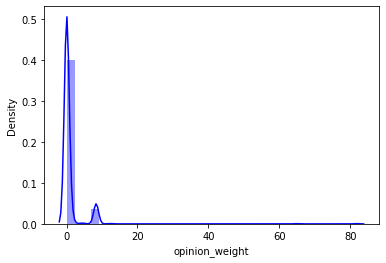

In [ ]:
import seaborn as sns
sns.distplot(retro_data['opinion_weight'],hist=True, 
             bins=int(180/5), color = 'blue')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


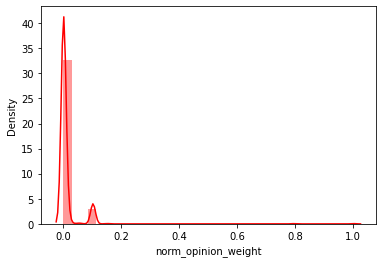

In [ ]:
sns.distplot(retro_data['norm_opinion_weight'],hist=True, 
             bins=int(180/5), color = 'red')

In [ ]:
retro_data['norm_opinion_weight'].describe()

count    9474.000000
mean        0.012245
std         0.052461
min         0.000010
25%         0.000010
50%         0.000020
75%         0.000886
max         1.000000
Name: norm_opinion_weight, dtype: float64

## Применение классификатора к выборке

In [ ]:
retro_probs = []
retro_sentiments = []
for tweet in retro_data['text']:
    sentence = Sentence(tweet)#автоматическая токенизация с помощью flair
    sentiment_model.predict(sentence) #отработка DistilBERT
    retro_probs.append(sentence.labels[0].score)
    retro_sentiments.append(sentence.labels[0].value) 
retro_data['probability'] = retro_probs
retro_data['sentiment'] = retro_sentiments

In [ ]:
retro_data.head(10)

,created_at,id,retweets,text,opinion_weight,norm_opinion_weight,probability,sentiment
0,2021-05-27T17:57:02.000Z,1397975146367959047,187.0,Since Tesla announced their #Bitcoin position...,0.153944,0.001894,0.867171,NEGATIVE
1,2021-05-27T17:57:02.000Z,1397975145604698113,0.0,FAD = full self-driving,0.000000,0.000010,0.953569,NEGATIVE
2,2021-05-27T17:57:02.000Z,1397975143750717445,5.0,Plaid Cymru Senedd Member writes to Elon Musk ...,0.004116,0.000060,0.836317,NEGATIVE
3,2021-05-27T17:56:58.000Z,1397975128202416128,57.0,Let me get this straight: 1/ Model S Plaid de...,0.046924,0.000584,0.990245,NEGATIVE
4,2021-05-27T17:56:56.000Z,1397975122523398149,0.0,💃🏾💃🏾💃🏾. Yeah the Tesla was not cutting it! Gl...,0.000000,0.000010,0.765093,POSITIVE
5,2021-05-27T17:56:56.000Z,1397975122435248130,0.0,🥳 Celebrate Webull’s 3rd Anniversary! Complete...,0.000000,0.000010,0.999709,POSITIVE
6,2021-05-27T17:56:53.000Z,1397975109181358082,0.0,Still illegal for Tesla to open up a store ri...,0.000000,0.000010,0.991829,NEGATIVE
7,2021-05-27T17:56:52.000Z,1397975104139763714,0.0,Reasons I want to buy Tesla: 1. You don’t have...,0.000000,0.000010,0.606770,POSITIVE
8,2021-05-27T17:56:52.000Z,1397975103321804806,70.0,"New #Tesla deliveries waiting in Superior, Co...",0.057626,0.000715,0.982219,POSITIVE
9,2021-05-27T17:56:51.000Z,1397975099358154759,0.0,We're talking to experts in the crypto and bl...,0.000000,0.000010,0.787429,POSITIVE


Посмотрим количество негативных и позитивных твитов

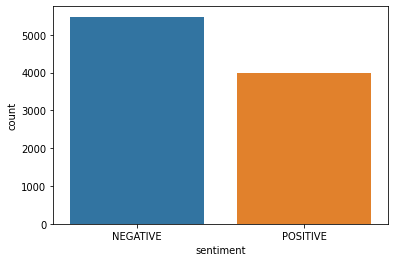

In [ ]:
sns.countplot(x = 'sentiment',data=retro_data)

## Загрузка данные о цене акций Tesla за период, соответствующий выборке

In [ ]:
import yfinance as yf
tsla = yf.Ticker("TSLA")
start = datetime.strptime(retro_data['created_at'].min(), '%Y-%m-%dT%H:%M:%S.%fZ')
end = datetime.strptime(retro_data['created_at'].max(), '%Y-%m-%dT%H:%M:%S.%fZ')
tsla_stock = tsla.history(
    start=start.strftime('%Y-%m-%d'),
    end=end.strftime('%Y-%m-%d'),
    interval='15m'
).reset_index()

In [ ]:
tsla_stock = pd.DataFrame(tsla_stock)
tsla_stock.head()

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-05-25 09:30:00-04:00,607.309998,613.989990,603.500000,604.109924,5700246,0,0
1,2021-05-25 10:00:00-04:00,603.890015,606.750000,601.750000,605.489990,3424590,0,0
2,2021-05-25 10:30:00-04:00,605.500000,606.099976,599.200989,603.020020,2767061,0,0
3,2021-05-25 11:00:00-04:00,603.030029,603.499390,597.020020,597.783020,2462487,0,0
4,2021-05-25 11:30:00-04:00,597.831482,600.500000,595.710022,600.049988,2191042,0,0


In [ ]:
tsla_stock.Datetime = tsla_stock.Datetime.dt.tz_convert(tz=None) #приведение к времени по гринвичу

## Разбиение результатов классификации по периодам, нахождение среднего и средневзвешенного результата. Объединение данных о цене и классификации.

In [ ]:
stock = pd.DataFrame()
stock['stock_datetime'] = tsla_stock['Datetime']
stock['close'] = tsla_stock['Close']
pred = pd.DataFrame()
pred['datetime'] = pd.to_datetime(retro_data['created_at']).dt.tz_convert(tz=None)
pred['n_weight'] = retro_data['norm_opinion_weight']
pred['prob'] = retro_data['probability']
pred['sent'] = retro_data['sentiment']
pred.loc[pred.sent == 'POSITIVE', 'sent'] = 1
pred.loc[pred.sent == 'NEGATIVE', 'sent'] = -1

Нормализуем цену акций от 0 до 1

In [ ]:
stock = stock.assign(normalized_price = (stock['close'] - stock['close'].min())/(stock['close'].max() - stock['close'].min()))
stock.head()

,stock_datetime,close,normalized_price
0,2021-05-25 13:30:00,604.109924,0.238060
1,2021-05-25 14:00:00,605.489990,0.289987
2,2021-05-25 14:30:00,603.020020,0.197050
3,2021-05-25 15:00:00,597.783020,0.000000
4,2021-05-25 15:30:00,600.049988,0.085298


In [ ]:
ds = stock.groupby(axis=0,by='stock_datetime').sum()

In [ ]:
time_start = stock.stock_datetime.min()
time_end = stock.stock_datetime.max()

Выберем значения времени из выборки, соответствующие времени торгов. Найдем значения среднего и средневзвешенного предсказания модели по периодам.

In [ ]:
pred.where((pred['datetime'] >= time_start)&(pred['datetime'] <= time_end), inplace=True)
pred.dropna(inplace=True)
pred.datetime = pred.datetime.dt.ceil('30T')#выбор периода
pred['probsent'] = pd.to_numeric(pred['prob'] * pred['sent'] + 1) 
pred['w_probsent'] = pd.to_numeric(pred['prob'] * pred['sent'] * pred['n_weight'] + 1)
pred

,datetime,n_weight,prob,sent,probsent,w_probsent
4485,2021-05-26 19:00:00,0.000040,0.999489,1,1.999489,1.000040
4486,2021-05-26 19:00:00,0.000050,0.990892,1,1.990892,1.000050
4487,2021-05-26 19:00:00,0.101928,0.998436,-1,0.001564,0.898232
4488,2021-05-26 19:00:00,0.004784,0.978617,-1,0.021383,0.995318
4489,2021-05-26 19:00:00,0.000010,0.999822,-1,0.000178,0.999990
...,...,...,...,...,...,...
9469,2021-05-25 18:30:00,0.000010,0.932410,1,1.932410,1.000009
9470,2021-05-25 18:30:00,0.001118,0.568511,-1,0.431489,0.999364
9471,2021-05-25 18:30:00,0.000060,0.998722,-1,0.001278,0.999940
9472,2021-05-25 18:30:00,0.018542,0.999522,1,1.999522,1.018534


In [ ]:
dp = pred.groupby(axis=0,by='datetime').mean()

Объединим значения в одну таблицу

In [ ]:
ex = pd.merge(ds, dp, left_index=True, right_index=True)
ex.index.rename('datetime',inplace=True)
#ex = ex.filter(like='2021-05-26',axis=0) если нужна фильтрация по определенному дню
ex

,close,normalized_price,n_weight,prob,probsent,w_probsent
datetime,,,,,,
2021-05-26 13:30:00,604.457520,0.251139,0.017873,0.938141,0.605530,0.983390
2021-05-26 14:00:00,609.455017,0.439177,0.008648,0.907734,0.908351,0.991937
2021-05-26 14:30:00,617.890015,0.756557,0.010610,0.932610,0.741679,0.989778
2021-05-26 15:00:00,617.260010,0.732852,0.013477,0.933792,0.934119,0.987299
2021-05-26 15:30:00,623.090027,0.952216,0.008569,0.949018,1.066207,0.993958
2021-05-26 16:00:00,621.109985,0.877714,0.010103,0.953764,0.812847,0.990186
2021-05-26 16:30:00,618.429993,0.776875,0.014200,0.961535,0.862236,0.985990
2021-05-26 17:00:00,621.780029,0.902925,0.010562,0.931535,0.852265,0.989728
2021-05-26 17:30:00,621.369995,0.887497,0.007193,0.956983,0.789180,0.993614


## Результаты
Некоторые результаты работы модели. По идее при эмоциональных продажах график цены должен повторять направление графика настроения с задержкой на какое-то время.

На 26.05

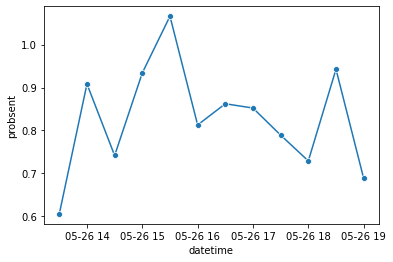

In [ ]:
sns.lineplot(data = ex, x ='datetime',y ='probsent' ,  marker="o")

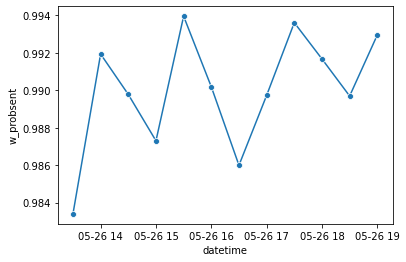

In [ ]:
sns.lineplot(data = ex, x ='datetime',y ='w_probsent', marker="o" )

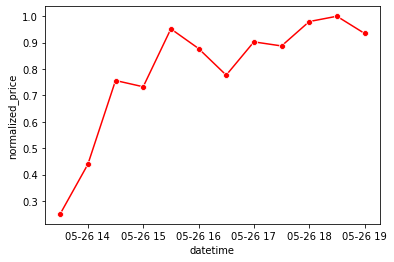

In [ ]:
sns.lineplot(data = ex,x = 'datetime', y = 'normalized_price', marker="o", color='r')

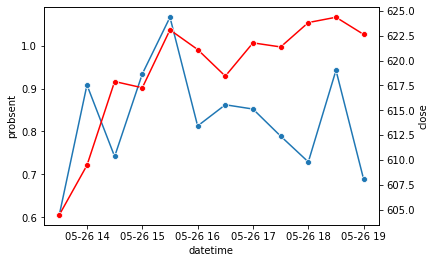

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.lineplot(x='datetime', y='probsent', data=ex, ax=ax, marker="o")
ax2 = ax.twinx()
sns.lineplot(x='datetime', y='close', data=ex, ax=ax2, color='r', marker="o")

С задержкой в 1 период график повторяет направление с точностью 0.66

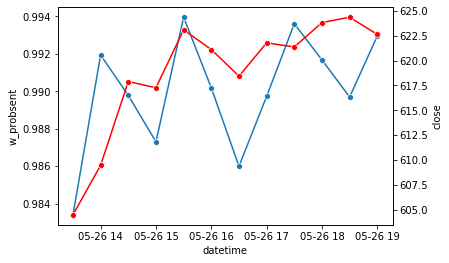

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x='datetime', y='w_probsent', data=ex, ax=ax, marker="o")
ax2 = ax.twinx()
sns.lineplot(x='datetime', y='close', data=ex, ax=ax2, color='r', marker="o")

На 28.05

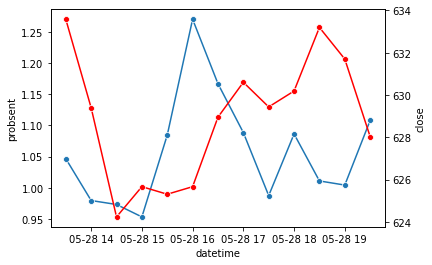

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x='datetime', y='probsent', data=ex, ax=ax, marker="o")
ax2 = ax.twinx()
sns.lineplot(x='datetime', y='close', data=ex, ax=ax2, color='r', marker="o")

С задержкой в 1 период график повторяет направление с точностью 0.73

# Опционально - сохранение помеченной выборки

In [ ]:
from google.colab import files
retro_data.to_csv('retro_data.csv', index=False)
files.download("retro_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Опционально - загрузка помеченной выборки


In [ ]:
from google.colab import files
import io
retro_data = pd.read_csv(io.BytesIO(uploaded['retro_data.csv']))

In [ ]:
retro_data.head()

,created_at,id,retweets,text,opinion_weight,norm_opinion_weight,probability,sentiment
0,2021-05-27T17:57:02.000Z,1397975146367959047,187.0,Since Tesla announced their #Bitcoin position...,0.153944,0.001894,0.867171,NEGATIVE
1,2021-05-27T17:57:02.000Z,1397975145604698113,0.0,FAD = full self-driving,0.000000,0.000010,0.953569,NEGATIVE
2,2021-05-27T17:57:02.000Z,1397975143750717445,5.0,Plaid Cymru Senedd Member writes to Elon Musk ...,0.004116,0.000060,0.836317,NEGATIVE
3,2021-05-27T17:56:58.000Z,1397975128202416128,57.0,Let me get this straight: 1/ Model S Plaid de...,0.046924,0.000584,0.990245,NEGATIVE
4,2021-05-27T17:56:56.000Z,1397975122523398149,0.0,💃🏾💃🏾💃🏾. Yeah the Tesla was not cutting it! Gl...,0.000000,0.000010,0.765093,POSITIVE
